In [32]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding =1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding =1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16, 1) #ant man
        self.bn3 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(16, 32, 3,padding =1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 32, 3,padding =1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32, 32, 3,padding =1)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.Conv2d(32, 16, 1)
        self.bn7 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv8 = nn.Conv2d(16,32,3,padding =1)
        self.bn8 = nn.BatchNorm2d(32)
        self.conv9 = nn.Conv2d(32, 32, 3,padding =1)
        self.bn9 = nn.BatchNorm2d(32)
        self.conv10 = nn.Conv2d(32,32,3,padding =1)
        self.bn10 = nn.BatchNorm2d(32)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.conv11 = nn.Conv2d(32, 10, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool2(x)
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = self.gap(x)
        x = x.squeeze(-1).squeeze(-1)

        return F.log_softmax(x, dim=1)

In [34]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             448
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 32, 28, 28]           4,640
       BatchNorm2d-4           [-1, 32, 28, 28]              64
            Conv2d-5           [-1, 16, 28, 28]             528
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           4,640
       BatchNorm2d-9           [-1, 32, 14, 14]              64
           Conv2d-10           [-1, 32, 14, 14]           9,248
      BatchNorm2d-11           [-1, 32, 14, 14]              64
           Conv2d-12           [-1, 32, 14, 14]           9,248
      BatchNorm2d-13           [-1, 32, 14, 14]              64
           Conv2d-14           [-1, 16,

In [35]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        # Get predictions and count correct ones
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        # Update progress bar description
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100.*correct/processed:.2f}%')

    # Print training accuracy for the epoch
    print('\nTrain set: Epoch: {}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, correct, len(train_loader.dataset), 100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_indices = []  # List to store indices of misclassified images
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Identify misclassified indices
            misclassified = ~pred.eq(target.view_as(pred))
            idxs = batch_idx * test_loader.batch_size + torch.nonzero(misclassified, as_tuple=False).reshape(-1)
            misclassified_indices.extend(idxs.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    # Print test accuracy
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

    return misclassified_indices

# def display_misclassified_images(misclassified_indices, dataset, num_images=10):
#     if len(misclassified_indices) < num_images:
#         num_images = len(misclassified_indices)
#     fig = plt.figure(figsize=(25, 4))
#     for idx, misclassified_index in enumerate(misclassified_indices[:num_images]):
#         ax = fig.add_subplot(2, num_images/2, idx+1, xticks=[], yticks=[])
#         image, label = dataset[misclassified_index]
#         image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to HxWxC format for displaying
#         ax.imshow(image)
#         ax.set_title(f'Index: {misclassified_index}\nPredicted: {label}')

def display_misclassified_images(misclassified_indices, dataset, num_images=10):
    if len(misclassified_indices) < num_images:
        num_images = len(misclassified_indices)
    num_cols = min(num_images // 2, 5)  # Limiting to 5 columns for better visualization
    fig = plt.figure(figsize=(25, 4))
    for idx, misclassified_index in enumerate(misclassified_indices[:num_images]):
        ax = fig.add_subplot(2, num_cols, idx+1, xticks=[], yticks=[])  # Ensure num_cols is an integer
        image, label = dataset[misclassified_index]
        image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to HxWxC format for displaying
        ax.imshow(image)
        ax.set_title(f'Index: {misclassified_index}\nPredicted: {label}')



In [36]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        # Get predictions and count correct ones
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        # Update progress bar description
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100.*correct/processed:.2f}%')

    # Print training accuracy for the epoch
    print('\nTrain set: Epoch: {}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, correct, len(train_loader.dataset), 100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_indices = []  # List to store indices of misclassified images
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Identify misclassified indices
            misclassified = ~pred.eq(target.view_as(pred))
            idxs = batch_idx * test_loader.batch_size + torch.nonzero(misclassified, as_tuple=False).reshape(-1)
            misclassified_indices.extend(idxs.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    # Print test accuracy
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

    return misclassified_indices

# def display_misclassified_images(misclassified_indices, dataset, num_images=10):
#     if len(misclassified_indices) < num_images:
#         num_images = len(misclassified_indices)
#     fig = plt.figure(figsize=(25, 4))
#     for idx, misclassified_index in enumerate(misclassified_indices[:num_images]):
#         ax = fig.add_subplot(2, num_images/2, idx+1, xticks=[], yticks=[])
#         image, label = dataset[misclassified_index]
#         image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to HxWxC format for displaying
#         ax.imshow(image)
#         ax.set_title(f'Index: {misclassified_index}\nPredicted: {label}')

def display_misclassified_images(misclassified_indices, dataset, num_images=10):
    if len(misclassified_indices) < num_images:
        num_images = len(misclassified_indices)
    num_cols = min(num_images // 2, 5)  # Limiting to 5 columns for better visualization
    fig = plt.figure(figsize=(25, 4))
    for idx, misclassified_index in enumerate(misclassified_indices[:num_images]):
        ax = fig.add_subplot(2, num_cols, idx+1, xticks=[], yticks=[])  # Ensure num_cols is an integer
        image, label = dataset[misclassified_index]
        image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to HxWxC format for displaying
        ax.imshow(image)
        ax.set_title(f'Index: {misclassified_index}\nPredicted: {label}')



Files already downloaded and verified


Loss=1.3232481479644775 Batch_id=390 Accuracy=47.58%: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s]



Train set: Epoch: 1, Accuracy: 23792/50000 (48%)



100%|██████████| 79/79 [00:13<00:00,  5.66it/s]



Test set: Average loss: 1.4700, Accuracy: 5232/10000 (52%)



Loss=1.0314087867736816 Batch_id=390 Accuracy=63.86%: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s]



Train set: Epoch: 2, Accuracy: 31929/50000 (64%)



100%|██████████| 79/79 [00:14<00:00,  5.60it/s]



Test set: Average loss: 1.3277, Accuracy: 5655/10000 (57%)



Loss=1.1209616661071777 Batch_id=390 Accuracy=69.28%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]



Train set: Epoch: 3, Accuracy: 34639/50000 (69%)



100%|██████████| 79/79 [00:13<00:00,  5.73it/s]



Test set: Average loss: 1.0829, Accuracy: 6395/10000 (64%)



Loss=0.8934265971183777 Batch_id=390 Accuracy=72.61%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]



Train set: Epoch: 4, Accuracy: 36306/50000 (73%)



100%|██████████| 79/79 [00:13<00:00,  5.68it/s]



Test set: Average loss: 0.8631, Accuracy: 7026/10000 (70%)



Loss=0.7254115343093872 Batch_id=390 Accuracy=75.05%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]



Train set: Epoch: 5, Accuracy: 37526/50000 (75%)



100%|██████████| 79/79 [00:13<00:00,  5.70it/s]



Test set: Average loss: 0.8304, Accuracy: 7184/10000 (72%)



Loss=0.8037440180778503 Batch_id=390 Accuracy=77.06%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s]



Train set: Epoch: 6, Accuracy: 38530/50000 (77%)



100%|██████████| 79/79 [00:13<00:00,  5.67it/s]



Test set: Average loss: 0.8410, Accuracy: 7153/10000 (72%)



Loss=0.6027301549911499 Batch_id=390 Accuracy=78.59%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]



Train set: Epoch: 7, Accuracy: 39293/50000 (79%)



100%|██████████| 79/79 [00:13<00:00,  5.79it/s]



Test set: Average loss: 0.8984, Accuracy: 6956/10000 (70%)



Loss=0.7652797698974609 Batch_id=390 Accuracy=79.72%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]



Train set: Epoch: 8, Accuracy: 39861/50000 (80%)



100%|██████████| 79/79 [00:14<00:00,  5.60it/s]



Test set: Average loss: 0.8430, Accuracy: 7181/10000 (72%)



Loss=0.4314480721950531 Batch_id=390 Accuracy=80.47%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]



Train set: Epoch: 9, Accuracy: 40236/50000 (80%)



100%|██████████| 79/79 [00:13<00:00,  5.79it/s]



Test set: Average loss: 0.8217, Accuracy: 7266/10000 (73%)



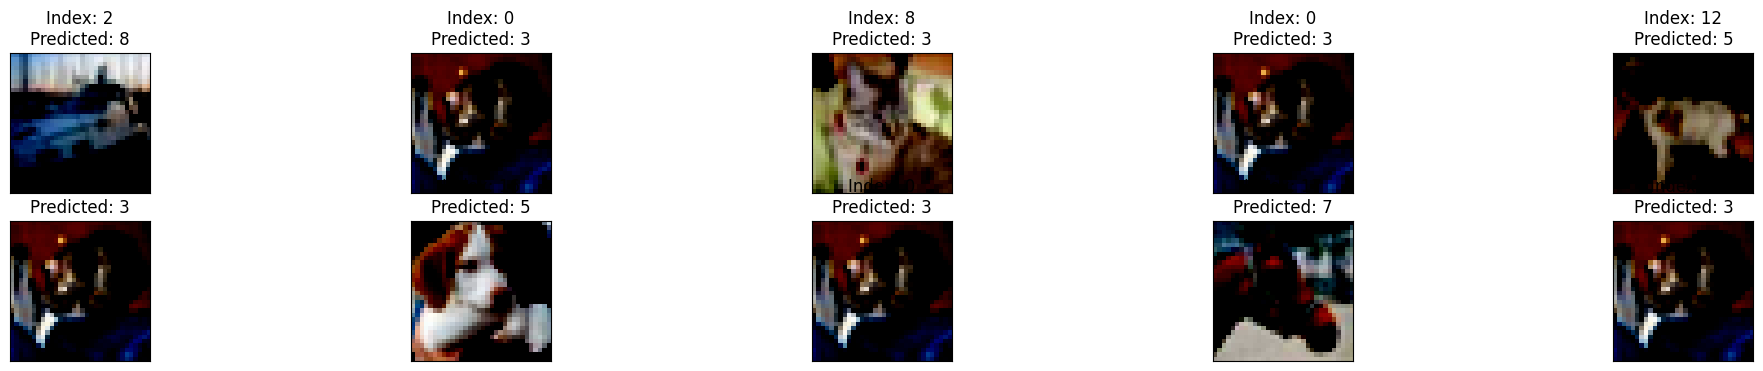

In [37]:
import torchvision
import torchvision.transforms as transforms
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch)
    x= test(model, device, test_loader)


display_misclassified_images(x, testset, num_images=10)